# Анализ системы дедупликации бинарных данных

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')

ALGO_COLORS = {'md5': '#E74C3C', 'sha256': '#2E86C1', 'sha512': '#27AE60'}
CHUNK_COLORS = {4: '#E74C3C', 32: '#E67E22', 128: '#2E86C1', 1024: '#27AE60'}

df = pd.read_csv('benchmark_results.csv')

df = df[df['file_size'] > 0].copy()
df = df[~df['file_name'].str.startswith('~$')].copy()
df.reset_index(drop=True, inplace=True)

# Базовый срез: sha256 (дубликаты одинаковы для всех алгоритмов)
sha = df[df['algo'] == 'sha256'].copy()
chunk_sizes = sorted(df['chunk_size'].unique())
origin_total = sha.groupby('file_name')['file_size'].first().sum()

print(f"Записей в CSV: {len(df)}")
print(f"Файлов: {df['file_name'].nunique()}")
print(f"Размеры сегментов: {chunk_sizes}")
print(f"Алгоритмы: {sorted(df['algo'].unique())}")
print(f"Исходный размер файлов: {origin_total:,} байт ({origin_total/1024:.1f} KB)")
df.head(18)

Записей в CSV: 288
Файлов: 24
Размеры сегментов: [np.int64(4), np.int64(32), np.int64(128), np.int64(1024)]
Алгоритмы: ['md5', 'sha256', 'sha512']
Исходный размер файлов: 716,344 байт (699.6 KB)


,file_name,file_size,chunk_size,algo,total_segments,unique_segments,duplicate_segments,storage_writes,time_hashing,time_total,storage_size
0,1688642977_75934327 (1).jpg,51994,4,md5,12999,12963,36,12963,0.350177,89.5395,51850
1,1688642977_75934327 (1).jpg,51994,4,sha256,12999,12963,36,12963,0.030295,89.5395,51850
2,1688642977_75934327 (1).jpg,51994,4,sha512,12999,12963,36,12963,0.342065,89.5395,51850
3,1688642977_75934327 (1).jpg,51994,32,md5,1625,1625,0,1625,0.042203,10.7284,51994
4,1688642977_75934327 (1).jpg,51994,32,sha256,1625,1625,0,1625,0.003387,10.7284,51994
5,1688642977_75934327 (1).jpg,51994,32,sha512,1625,1625,0,1625,0.040522,10.7284,51994
6,1688642977_75934327 (1).jpg,51994,128,md5,407,407,0,407,0.010467,2.6899,51994
7,1688642977_75934327 (1).jpg,51994,128,sha256,407,407,0,407,0.000901,2.6899,51994
8,1688642977_75934327 (1).jpg,51994,128,sha512,407,407,0,407,0.010332,2.6899,51994
9,1688642977_75934327 (1).jpg,51994,1024,md5,51,51,0,51,0.001341,0.3326,51994


## 1. Сравнение времени обработки по размерам сегментов

`time_total` — полное время прохода (чтение + хэширование + БД + хранилище).  
Левый график: общее время. Правый: среднее время на 1 сегмент — показывает, что overhead на сегмент примерно одинаковый, а разница в общем времени из-за количества сегментов.

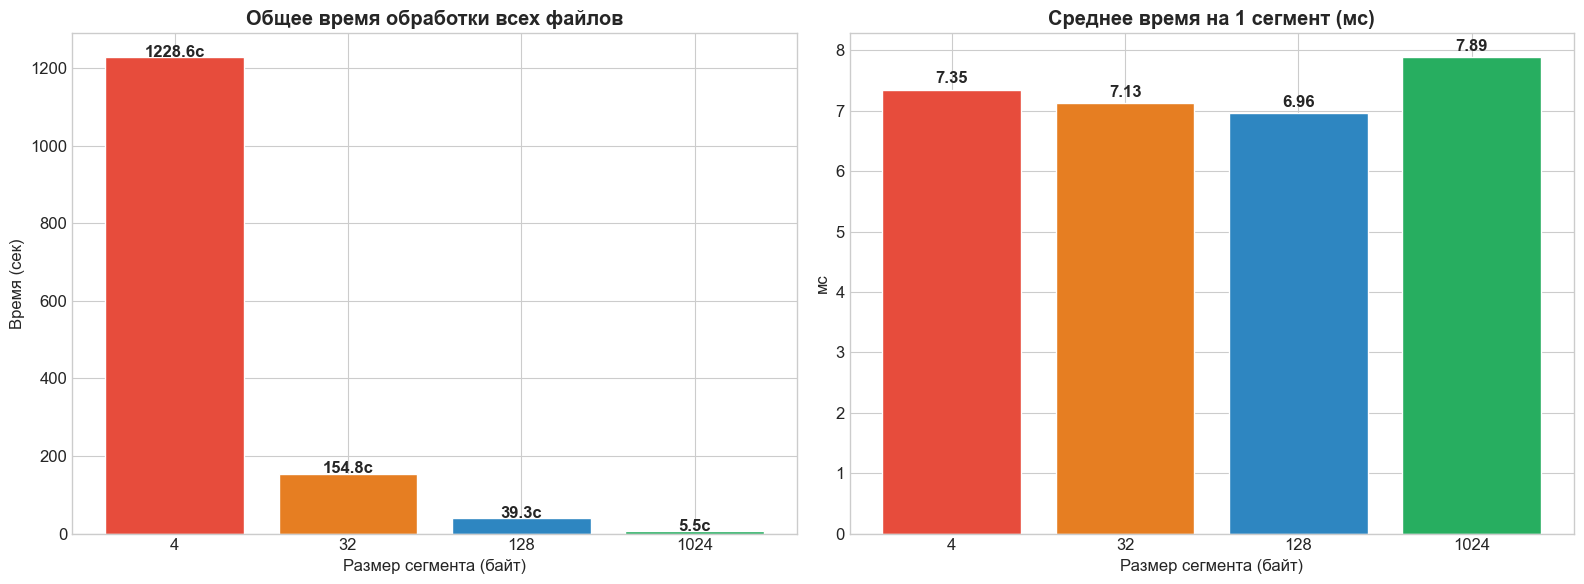

In [11]:
time_by_chunk = sha.groupby('chunk_size')['time_total'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Общее время
ax = axes[0]
bars = ax.bar(time_by_chunk['chunk_size'].astype(str), time_by_chunk['time_total'],
              color=[CHUNK_COLORS[c] for c in time_by_chunk['chunk_size']], edgecolor='white')
for bar, val in zip(bars, time_by_chunk['time_total']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}с', ha='center', fontweight='bold')
ax.set_title('Общее время обработки всех файлов', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Время (сек)')

# Среднее время на 1 сегмент
sha_nz = sha[sha['total_segments'] > 0].copy()
sha_nz['ms_per_seg'] = sha_nz['time_total'] / sha_nz['total_segments'] * 1000
tps = sha_nz.groupby('chunk_size')['ms_per_seg'].mean().reset_index()

ax = axes[1]
bars = ax.bar(tps['chunk_size'].astype(str), tps['ms_per_seg'],
              color=[CHUNK_COLORS[c] for c in tps['chunk_size']], edgecolor='white')
for bar, val in zip(bars, tps['ms_per_seg']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}', ha='center', fontweight='bold')
ax.set_title('Среднее время на 1 сегмент (мс)', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('мс')

plt.tight_layout()
plt.show()

## 2. Уникальные и дублирующиеся сегменты

Важно различать **два уровня** подсчёта дубликатов:

| Метрика | Откуда | Что значит |
|---------|--------|------------|
| `duplicate_segments` (CSV) | Бенчмарк | Сколько раз при обработке файлов мы встретили сегмент, который **уже был в БД**. Это число совпадений за весь прогон. |
| `repits` (PostgreSQL) | Таблица `unique_segments` | Абсолютное кол-во вхождений сегмента. Если `repits = 5`, значит сегмент встречается в 5 местах (в 1 файле или в разных). |

Пример: сегмент `0xABC` встречается в 3 файлах.  
- При обработке 1-го файла: unique (записали).  
- При обработке 2-го: duplicate (+1).  
- При обработке 3-го: duplicate (+1).  
- CSV: `duplicate_segments` += 2 в сумме.  
- БД: `repits = 3`.

### 2.1 Общая картина из CSV

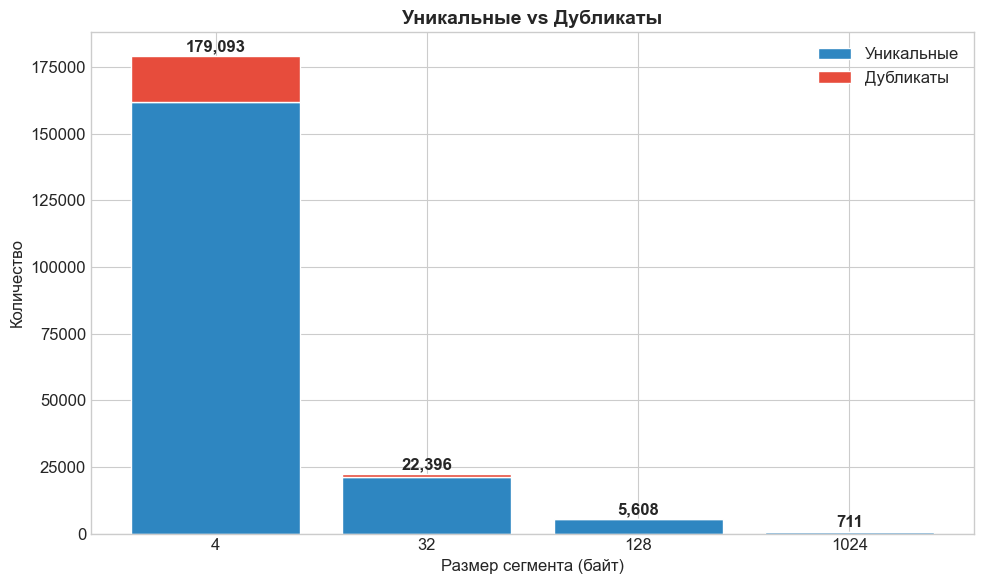

,chunk_size,total,unique,duplicate
0,4,179093,161811,17282
1,32,22396,21340,1056
2,128,5608,5433,175
3,1024,711,706,5


In [12]:
seg = sha.groupby('chunk_size').agg(
    total=('total_segments', 'sum'),
    unique=('unique_segments', 'sum'),
    duplicate=('duplicate_segments', 'sum'),
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar
ax.bar(seg['chunk_size'].astype(str), seg['unique'], label='Уникальные', color='#2E86C1', edgecolor='white')
ax.bar(seg['chunk_size'].astype(str), seg['duplicate'], bottom=seg['unique'], label='Дубликаты', color='#E74C3C', edgecolor='white')

# Adding labels
for i, row in seg.iterrows():
    ax.text(i, row['total'] + (seg['total'].max() * 0.01), f"{row['total']:,}", ha='center', fontweight='bold')

ax.set_title('Уникальные vs Дубликаты', fontweight='bold', fontsize=14)
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Количество')
ax.legend()

plt.tight_layout()
plt.show()

seg_res = pd.DataFrame(seg)
seg_res

### 2.2 Глубокий анализ повторений (repits) - SQL-запросы

Запросы выполнялись в PostgreSQL

#### 2.2.1. Распределение: сколько сегментов встречается 1 раз, 2 раза, 3 раза и т.д.

SQL-запрос:

```sql
SELECT repits, COUNT(*) AS segments_count, 
       SUM(segment_size) AS total_bytes
FROM unique_segments_4_sha256
GROUP BY repits ORDER BY repits;
```

In [13]:
q_1_file = "SQL_csv_files/_SELECT_repits_COUNT_AS_segments_count_SUM_segment_size_AS_total_202602250122.csv"
query_1 = pd.read_csv(q_1_file)
query_1 = query_1[['repits', 'segments_count']]
query_1.sort_values(by="repits", ascending=True)

,repits,segments_count
0,1,158425
1,2,2449
2,3,290
3,4,142
4,5,120
5,6,194
6,7,37
7,8,32
8,9,30
9,10,15


#### 2.2.2. Топ-20 самых повторяющихся сегментов

SQL-запрос:

```sql
SELECT segment_hash, repits, segment_size
FROM unique_segments_4_sha256
ORDER BY repits DESC LIMIT 20;
```

In [14]:
q_2_file = "SQL_csv_files/unique_segments_4_sha256_202602250141.csv"
query_2 = pd.read_csv(q_2_file)
query_2

,segment_hash,repits,segment_size
0,df3f619804a92fdb4057192dc43dd748ea778adc52bc49...,7714,4
1,ccd6c7f350a3fba172643c3f4fd8c0dd4d26a594e0420b...,251,4
2,4f22d4ae858058f95323eddf3154523093ef99d8d4811b...,251,4
3,7370bed9355d308a47b6711135e981e04e445837153f33...,248,4
4,762e3223bedbec50976e5c3587ad556cfb38f0ce932a87...,199,4
5,064a75343ddb1ef84626a5d3d2089a0a5b0398f4379449...,195,4
6,3266d2f428d53cd9a1b1464cd5c01246b83468c39cb085...,188,4
7,83440636eff7b2ec0f78ef7b8e480a033e8aeb67e6ecb6...,95,4
8,9bebc47eada08a45423a457d12347ad5f8f359434f0c56...,91,4
9,dc765660b06ee03dd16fd7ca5b957e8c805161ac2c4af2...,82,4


#### 2.2.3. Экономия в байтах

SQL-запрос:

```sql
SELECT
    SUM(segment_size)                   AS stored_bytes,
    SUM(repits * segment_size)          AS without_dedup_bytes,
    SUM((repits - 1) * segment_size)    AS saved_bytes,
    '4'                                 AS segment_syze
    
FROM unique_segments_4_sha256

UNION ALL

SELECT
    SUM(segment_size)                   AS stored_bytes,
    SUM(repits * segment_size)          AS without_dedup_bytes,
    SUM((repits - 1) * segment_size)    AS saved_bytes,
    '32'                                AS segment_syze
FROM unique_segments_32_sha256

UNION all

SELECT
    SUM(segment_size)                   AS stored_bytes,
    SUM(repits * segment_size)          AS without_dedup_bytes,
    SUM((repits - 1) * segment_size)    AS saved_bytes,
    '128'                               AS segment_syze
FROM unique_segments_128_sha256

UNION ALL

SELECT
    SUM(segment_size)                   AS stored_bytes,
    SUM(repits * segment_size)          AS without_dedup_bytes,
    SUM((repits - 1) * segment_size)    AS saved_bytes,
    '1024'                              AS segment_syze
FROM unique_segments_1024_sha256

```

In [15]:
q_3_file = "SQL_csv_files/_SELECT_SUM_segment_size_AS_stored_bytes_SUM_repits_segment_size_202602250151.csv"

query_3 = pd.read_csv(q_3_file)
query_3

,stored_bytes,without_dedup_bytes,saved_bytes,segment_syze
0,647329,716506,69177,4
1,682714,716506,33792,32
2,694106,716506,22400,128
3,711386,716506,5120,1024


## 3. Коэффициент дедупликации

**Dedup Rate** = `duplicate_segments / total_segments × 100%`  


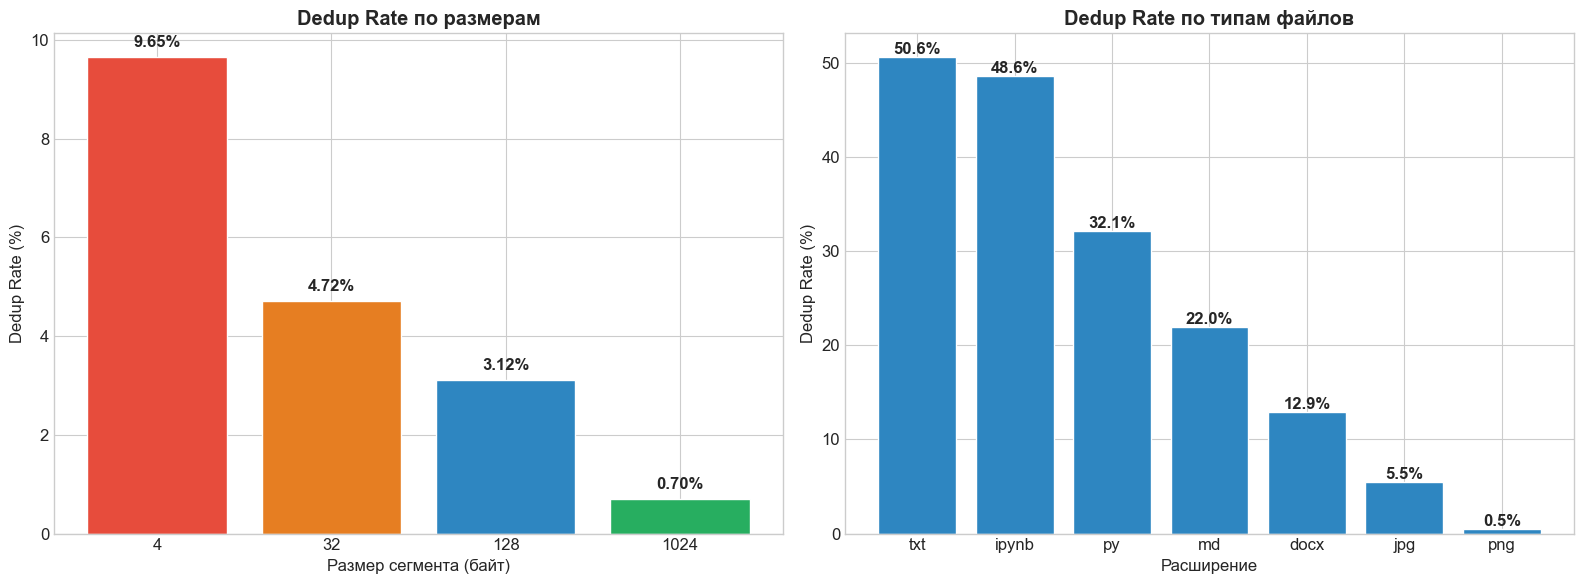

,chunk_size,total,dupes,dedup_rate
0,4,179093,17282,9.65
1,32,22396,1056,4.72
2,128,5608,175,3.12
3,1024,711,5,0.70


In [16]:
rate = sha.groupby('chunk_size').agg(
    total=('total_segments', 'sum'),
    dupes=('duplicate_segments', 'sum'),
).reset_index()
rate['dedup_rate'] = (rate['dupes'] / rate['total'] * 100).round(2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# По chunk_size
ax = axes[0]
bars = ax.bar(rate['chunk_size'].astype(str), rate['dedup_rate'],
              color=[CHUNK_COLORS[c] for c in rate['chunk_size']], edgecolor='white')
for bar, val in zip(bars, rate['dedup_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.2f}%', ha='center', fontweight='bold', fontsize=12)
ax.set_title('Dedup Rate по размерам', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Dedup Rate (%)')

# По типам файлов
sha_ext = sha.copy()
sha_ext['ext'] = sha_ext['file_name'].apply(lambda x: x.rsplit('.', 1)[-1].lower() if '.' in x else '?')
rate_ext = sha_ext.groupby('ext').agg(
    total=('total_segments', 'sum'), dupes=('duplicate_segments', 'sum')
).reset_index()
rate_ext['dedup_rate'] = (rate_ext['dupes'] / rate_ext['total'] * 100).round(2)
rate_ext = rate_ext.sort_values('dedup_rate', ascending=False)

ax = axes[1]
bars = ax.bar(rate_ext['ext'], rate_ext['dedup_rate'], color='#2E86C1', edgecolor='white')
for bar, val in zip(bars, rate_ext['dedup_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{val:.1f}%', ha='center', fontweight='bold')
ax.set_title('Dedup Rate по типам файлов', fontweight='bold')
ax.set_xlabel('Расширение')
ax.set_ylabel('Dedup Rate (%)')

plt.tight_layout()
plt.show()

rate = pd.DataFrame(rate)
rate

## 4. Сравнение размеров: оригинал vs хранилище

Каждое хранилище `storage_{size}.bin` содержит **все уникальные сегменты** для данного chunk_size.  
Размер > 100% от оригинала означает overhead от хранения одних и тех же данных в разной нарезке.

In [17]:
# Размеры хранилищ с диска
storage_dir = './data_storage'
storage_sizes = {}

if os.path.exists(storage_dir):
    for cs in chunk_sizes:
        path = os.path.join(storage_dir, f'storage_{cs}.bin')
        storage_sizes[cs] = os.path.getsize(path) if os.path.exists(path) else 0
    source = "с диска"
else:
    for cs in chunk_sizes:
        storage_sizes[cs] = int(df[df['chunk_size'] == cs]['storage_size'].max())
    source = "из CSV (максимальное значение storage_size)"

print(f"Источник: {source}")
print(f"Оригинал (origin_data): {origin_total:,} байт ({origin_total/1024:.1f} KB)\n")
for cs, sz in storage_sizes.items():
    pct = sz / origin_total * 100
    print(f"  storage_{cs}.bin: {sz:>10,} байт  ({pct:>6.1f}% от оригинала)")

total_all = sum(storage_sizes.values())
print(f"\n  ИТОГО хранилища: {total_all:,} байт ({total_all / origin_total:.2f}x от оригинала)")

Источник: из CSV (максимальное значение storage_size)
Оригинал (origin_data): 716,344 байт (699.6 KB)

  storage_4.bin:    647,329 байт  (  90.4% от оригинала)
  storage_32.bin:    682,714 байт  (  95.3% от оригинала)
  storage_128.bin:    694,106 байт  (  96.9% от оригинала)
  storage_1024.bin:    711,386 байт  (  99.3% от оригинала)

  ИТОГО хранилища: 2,735,535 байт (3.82x от оригинала)


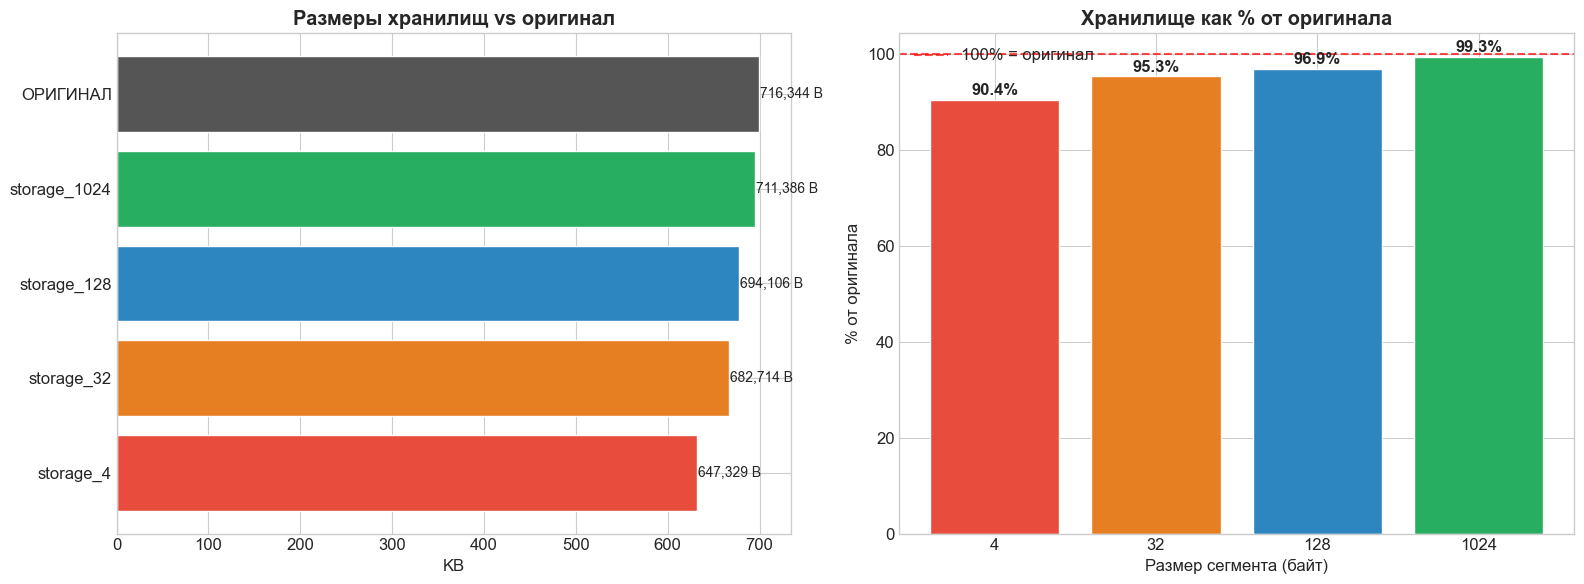

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Горизонтальный bar
ax = axes[0]
labels = [f'storage_{cs}' for cs in chunk_sizes] + ['ОРИГИНАЛ']
sizes = [storage_sizes[cs] for cs in chunk_sizes] + [origin_total]
colors_list = [CHUNK_COLORS[cs] for cs in chunk_sizes] + ['#555555']

bars = ax.barh(labels, [s / 1024 for s in sizes], color=colors_list, edgecolor='white')
for bar, val in zip(bars, sizes):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{val:,} B', va='center', fontsize=10)
ax.set_title('Размеры хранилищ vs оригинал', fontweight='bold')
ax.set_xlabel('KB')

# Процент от оригинала
ax = axes[1]
eff = [storage_sizes[cs] / origin_total * 100 for cs in chunk_sizes]
bars = ax.bar([str(cs) for cs in chunk_sizes], eff,
              color=[CHUNK_COLORS[cs] for cs in chunk_sizes], edgecolor='white')
ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% = оригинал')
for bar, val in zip(bars, eff):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', fontweight='bold')
ax.set_title('Хранилище как % от оригинала', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('% от оригинала')
ax.legend()

plt.tight_layout()
plt.show()

## 5. Дополнительные метрики

### 5.1 Пропускная способность
Сколько KB/s система обрабатывает при разных chunk_size.

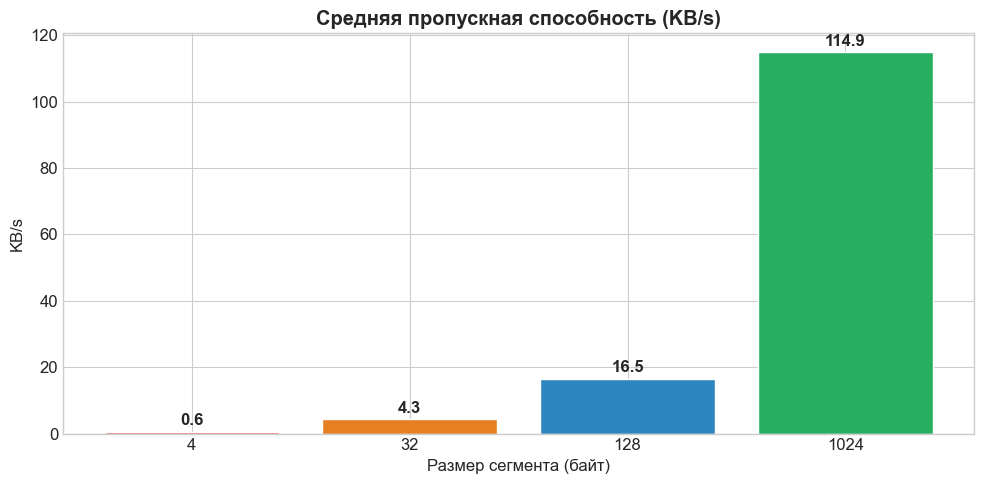

Крупные сегменты - значительно быстрее (меньше обращений к БД на тот же объём данных).


In [19]:
sha_tp = sha[sha['time_total'] > 0].copy()
sha_tp['throughput_kbps'] = sha_tp['file_size'] / 1024 / sha_tp['time_total']
tp = sha_tp.groupby('chunk_size')['throughput_kbps'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(tp['chunk_size'].astype(str), tp['throughput_kbps'],
              color=[CHUNK_COLORS[c] for c in tp['chunk_size']], edgecolor='white')
for bar, val in zip(bars, tp['throughput_kbps']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.1f}', ha='center', fontweight='bold')
ax.set_title('Средняя пропускная способность (KB/s)', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('KB/s')
plt.tight_layout()
plt.show()

print("Крупные сегменты - значительно быстрее (меньше обращений к БД на тот же объём данных).")

### 5.2 Консистентность алгоритмов

Проверка: все ли алгоритмы находят одинаковое количество уникальных сегментов?  
Если расхождение - возможна **хэш-коллизия** (два разных блока дали одинаковый хэш).

In [20]:
cons = df.pivot_table(index=['file_name', 'chunk_size'], columns='algo',
                      values='unique_segments', aggfunc='first')
cons['consistent'] = cons.apply(lambda r: r.nunique() == 1, axis=1)
bad = cons[~cons['consistent']]

if len(bad) == 0:
    print(" Все алгоритмы дают одинаковое количество уникальных сегментов.")
    print(" Коллизий не обнаружено ни для одной пары (файл × chunk_size).")
else:
    print(f"{len(bad)} расхождений — возможны коллизии:")
    print(bad)

 Все алгоритмы дают одинаковое количество уникальных сегментов.
 Коллизий не обнаружено ни для одной пары (файл × chunk_size).


### 5.3 Экономия хранилища (Storage Savings)

Сравнение: сколько бы заняли данные **без дедупликации** (сумма file_size) vs реальный размер хранилища.

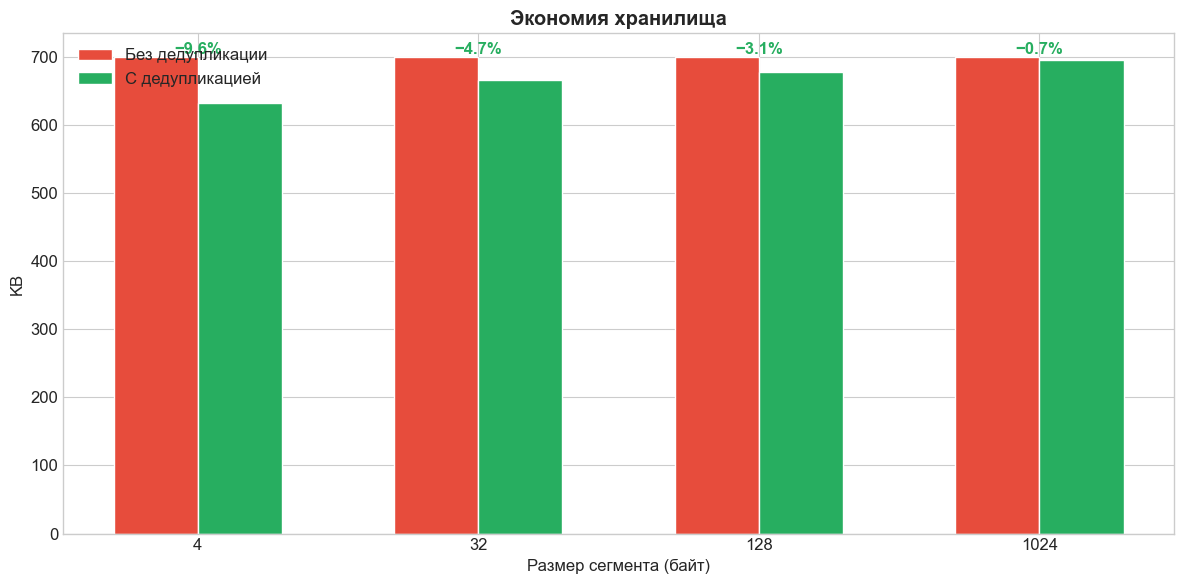

,chunk_size,without_dedup,with_dedup,saved,saving_%
0,4,716344.0,647329.0,69015.0,9.634338
1,32,716344.0,682714.0,33630.0,4.694672
2,128,716344.0,694106.0,22238.0,3.104374
3,1024,716344.0,711386.0,4958.0,0.692126


In [21]:
savings = pd.DataFrame({'chunk_size': chunk_sizes})
for i, cs in enumerate(chunk_sizes):
    without = sha[sha['chunk_size'] == cs]['file_size'].sum()
    actual = storage_sizes[cs]
    savings.at[i, 'without_dedup'] = without
    savings.at[i, 'with_dedup'] = actual
    savings.at[i, 'saved'] = without - actual
    savings.at[i, 'saving_%'] = ((without - actual) / without * 100) if without > 0 else 0

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(savings))
w = 0.3
ax.bar([i - w/2 for i in x], savings['without_dedup'] / 1024, w,
       label='Без дедупликации', color='#E74C3C', edgecolor='white')
ax.bar([i + w/2 for i in x], savings['with_dedup'] / 1024, w,
       label='С дедупликацией', color='#27AE60', edgecolor='white')
ax.set_xticks(list(x))
ax.set_xticklabels(savings['chunk_size'].astype(int).astype(str))
for i, row in savings.iterrows():
    ax.text(i, max(row['without_dedup'], row['with_dedup']) / 1024 + 5,
            f"−{row['saving_%']:.1f}%", ha='center', fontweight='bold', color='#27AE60')
ax.set_title('Экономия хранилища', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('KB')
ax.legend()
plt.tight_layout()
plt.show()

savings

### 5.4 Сводная таблица

In [22]:
summary = sha.groupby('chunk_size').agg(
    files=('file_name', 'nunique'),
    total_segments=('total_segments', 'sum'),
    unique_segments=('unique_segments', 'sum'),
    duplicate_segments=('duplicate_segments', 'sum'),
    total_time_sec=('time_total', 'sum'),
).reset_index()

summary['dedup_rate_%'] = (summary['duplicate_segments'] / summary['total_segments'] * 100).round(2)
summary['avg_ms_per_seg'] = (summary['total_time_sec'] / summary['total_segments'] * 1000).round(2)
summary['storage_KB'] = [round(storage_sizes[cs] / 1024, 1) for cs in summary['chunk_size']]
summary['throughput_KB/s'] = (
    sha[sha['time_total'] > 0].groupby('chunk_size')
    .apply(lambda g: g['file_size'].sum() / 1024 / g['time_total'].sum())
    .values
).round(1)

summary = pd.DataFrame(summary)
summary

,chunk_size,files,total_segments,unique_segments,duplicate_segments,total_time_sec,dedup_rate_%,avg_ms_per_seg,storage_KB,throughput_KB/s
0,4,24,179093,161811,17282,1228.6485,9.65,6.86,632.2,0.6
1,32,24,22396,21340,1056,154.7789,4.72,6.91,666.7,4.5
2,128,24,5608,5433,175,39.3025,3.12,7.01,677.8,17.8
3,1024,24,711,706,5,5.4789,0.70,7.71,694.7,127.7
